## France's high voltage network

Enedis (Electricity of France) recently (2018/05/16) released their networks as open geographical data. Let us try to load these data, plot and analyze them. We focus here on the high-voltage network: "lignes HTA" (the low-voltage network has also been made available as "lignes BT").

The network "lignes HTA" can be downloaded from the Enedis [data portal](https://data.enedis.fr/explore/dataset/reseau-hta/export/). Here we chose the GeoJSON file for the geographical data: reseau-hta.geojson (276.8 MB).

### Imports

In [1]:
%matplotlib inline
import pandas as pd  # 0.23.0
import geopandas as gpd  # 0.3.0
from shapely.geometry import LineString, MultiLineString, Polygon  # 1.6.4
from shapely import ops
from shapely.wkt import loads

### Load the data

It is also possible to download the data as a CSV file. The loading part with Pandas is really faster, however one has then to convert the geometry from a text format to a [shapely](https://shapely.readthedocs.io/en/latest/) geometric object.

In [2]:
%time hta = gpd.read_file('reseau-hta.geojson')

CPU times: user 52 s, sys: 1.71 s, total: 53.7 s
Wall time: 53.6 s


### Inspect the data

In [3]:
hta.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1102066 entries, 0 to 1102065
Data columns (total 1 columns):
geometry    1102066 non-null object
dtypes: object(1)
memory usage: 8.4+ MB


In [4]:
hta.head(2)

,geometry
0,LINESTRING (0.275708182098627 47.1093150681570...
1,LINESTRING (0.495070935821371 46.9768407284384...


In [5]:
hta.crs

{'init': 'epsg:4326'}

So we have a geodataframe with a single column of 1102066 geometric entities. Note that GeoPandas took care of the coordinate reference system and reprojected the data to WGS 84 (World Geodetic System, EPSG4326). The original data was set in [RGF93](http://spatialreference.org/ref/epsg/rgf93-lambert-93/). Now let us look as the different geometry types:

In [6]:
hta['geom_type'] = hta.geometry.geom_type
hta.geom_type.value_counts()

LineString         1088976
MultiLineString      13090
dtype: int64

We have either `LineString` or `MultiLineString` objects. 

### Merge contiguous linestrings

By printing the first MultiLineString geometries, it appears that they look like two contiguous linestrings: the last point of the first line is the first point of the second line:

In [7]:
hta_multistrings = hta[hta.geom_type=='MultiLineString']
for i in range(5):
    print(hta_multistrings.iloc[i].geometry)

MULTILINESTRING ((5.685749462665464 45.4933603463797, 5.692583099821639 45.49271731503835), (5.692583099821639 45.49271731503835, 5.694533048595929 45.4927184074988))
MULTILINESTRING ((5.831607690311678 45.21450288626659, 5.831812772907658 45.21445980673872, 5.8318396154852 45.2145150611225), (5.8318396154852 45.2145150611225, 5.831845819911392 45.21452782324677))
MULTILINESTRING ((-0.828052361910001 46.6033272582639, -0.828082033002592 46.6033096416577), (-0.828082033002592 46.6033096416577, -0.828096135593586 46.60330126308212))
MULTILINESTRING ((3.408964986257356 45.96535585521448, 3.392933399314529 45.97251179704767), (3.392933399314529 45.97251179704767, 3.392922907219469 45.97251648455421))
MULTILINESTRING ((5.742027837681316 44.78330775954034, 5.741575221139959 44.78318747499932), (5.741575221139959 44.78318747499932, 5.741557476955085 44.78318275563127))


Let us merge these contiguous lines with `shapely.ops.linemerge` (which is not going to merge discontinuous LineStrings):

In [8]:
hta.loc[hta.geom_type=='MultiLineString', 'geometry'] = hta.loc[hta.geom_type=='MultiLineString', 'geometry'].map(ops.linemerge)

In [9]:
hta['geom_type'] = hta.geometry.geom_type
hta.geom_type.value_counts()

LineString    1102066
dtype: int64

There is no more `MultiLineString` objects! They were all couples of contiguous lines. Why were they splitted into different lines? I have no idea...

### Sketch the data

CPU times: user 33.2 s, sys: 552 ms, total: 33.7 s
Wall time: 33.1 s


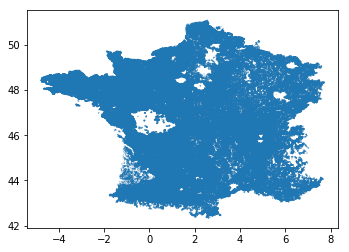

In [10]:
%time hta.plot()

It seems that some parts of France do not have electricty yet! Or, more probably :), they are managed by other companies (Enedis manages the public electricity distribution network for 95% of continental France). Let us zoom in the Auvergne-Rhône-Alpes region (GeoPandas has a very neat coordinate based indexing: the `.cx` indexer, which slices using a bounding box) and the Rhône department:

In [11]:
%time hta_ara = hta.cx[2.06:7.19, 44.12:46.8].copy(deep=True)

CPU times: user 38 s, sys: 83.8 ms, total: 38.1 s
Wall time: 38.1 s


In [12]:
print(len(hta_ara))

210905


The `.cx` indexer is probably not using a spatial index as when using `.sjoin`? Let us compare the elapsed time.

First we start by creating a single row `GeoDataFrame` containing the Auvergne-Rhône-Alpes region geometry.

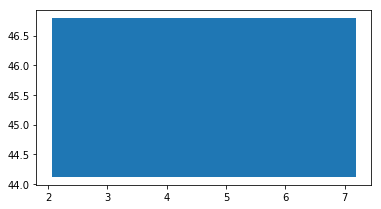

In [13]:
ara_geom = loads('POLYGON((2.06 46.8, 7.19 46.8, 7.19 44.12, 2.06 44.12, 2.06 46.8))')
ara_geom = gpd.GeoDataFrame(data=['blabla'], geometry=[ara_geom])
ara_geom.crs = {'init': 'epsg:4326'}
ara_geom.plot()

This looks like the contour map of Wyoming.

In [14]:
%time hta_ara_2 = gpd.sjoin(hta, ara_geom, how="inner", op='intersects')

CPU times: user 59.5 s, sys: 275 ms, total: 59.8 s
Wall time: 59.7 s


In [15]:
print(len(hta_ara_2))

210905


Well `.sjoin` is actually slower that `.cx`... About twice as slow! So jut use `.cx` for bounding box spatial selections.

CPU times: user 6.34 s, sys: 180 ms, total: 6.52 s
Wall time: 6.3 s


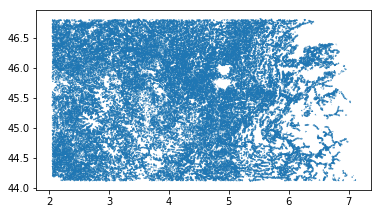

In [16]:
%time hta_ara.plot()

In [17]:
%time hta_rhone = hta_ara.cx[4.2436:5.1603, 45.454:46.3065].copy(deep=True)

CPU times: user 7.97 s, sys: 32 ms, total: 8.01 s
Wall time: 8 s


CPU times: user 778 ms, sys: 116 ms, total: 894 ms
Wall time: 719 ms


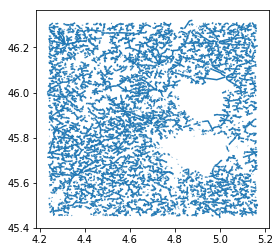

In [18]:
%time hta_rhone.plot()

### Compute network's length

In the EPSG4326 projection, coordinates correspond to angles: longitude and latitude. Thus the `LineString` length is not goint to be helpful. Let us start by changing the CRS to a more appropriate one (EPSG:2154, RGF93 / Lambert-93) based on metric system:

In [19]:
%time hta.to_crs(epsg=2154, inplace=True)

CPU times: user 32.8 s, sys: 240 ms, total: 33 s
Wall time: 33 s


In [20]:
%time hta['length'] = hta.geometry.length

CPU times: user 2.54 s, sys: 20 ms, total: 2.56 s
Wall time: 2.56 s


In [21]:
hta.head(2)

,geometry,geom_type,length
index_left,,,
0,LINESTRING (493450.4983000009 6671236.06979999...,LineString,316.533531
1,LINESTRING (509609.5552000029 6655978.72149999...,LineString,7.437865


In [22]:
hta.length.sum()

327098209.6888636

This means that we have 327098 km of high-voltage network here!

We convert the geometry back to the EPSG4326 CRS.

In [23]:
%time hta.to_crs(epsg=4326, inplace=True)

CPU times: user 35.1 s, sys: 200 ms, total: 35.3 s
Wall time: 35.3 s


### Creating a graph

In [24]:
hta_ara["tail_coords"] = hta_ara.geometry.map(lambda p: f'{p.coords[0][0]:11.8f}, {p.coords[0][1]:11.8f}')
hta_ara["head_coords"] = hta_ara.geometry.map(lambda p: f'{p.coords[-1][0]:11.8f}, {p.coords[-1][1]:11.8f}')

In [25]:
nodes = pd.concat([hta_ara[["tail_coords"]].rename(columns={"tail_coords": "coords"}), 
                   hta_ara[["head_coords"]].rename(columns={"head_coords": "coords"})], axis=0)
nodes.drop_duplicates(subset=['coords'], inplace=True)

In [26]:
nodes.reset_index(drop=True, inplace=True)
nodes["idx"] = nodes.index

In [27]:
hta_ara = pd.merge(hta_ara, nodes, left_on='tail_coords', right_on='coords', how='left')
hta_ara.drop(['coords'], axis=1, inplace=True)
hta_ara.rename(columns={'idx': 'tail'}, inplace=True)

In [28]:
hta_ara = pd.merge(hta_ara, nodes, left_on='head_coords', right_on='coords', how='left')
hta_ara.drop(['coords'], axis=1, inplace=True)
hta_ara.rename(columns={'idx': 'head'}, inplace=True)

In [29]:
hta_ara.drop(['tail_coords', 'head_coords'], axis=1, inplace=True)

In [35]:
edges = hta_ara[['tail', 'head']].copy(deep=True)
edges.rename(columns={'tail': 'source', 'head': 'target'}, inplace=True)

In [41]:
edges.head(2)

,source,target
0,0,128569
1,1,128570


In [42]:
nodes['x'] = nodes.coords.map(lambda s: float(s.split(',')[0]))
nodes['y'] = nodes.coords.map(lambda s: float(s.split(',')[1]))
nodes['name'] = nodes.index.map(lambda i: "node"+str(i))
nodes.drop(['idx', 'coords'], axis=1, inplace=True)

In [43]:
nodes.head(2)

,x,y,name
0,5.341136,45.085844,node0
1,5.201205,45.151761,node1
